In [1]:
# Procedure
#    check_subevent
# Parameters
#    tags, Dict(), contains tag ID and label for a particular event
#    id, Int64, tag ID, used to check whether it is present in tags
# Purpose
#    Returns true if id is found in tags, otherwise returns false
# Produced
#    boolean
# Preconditions
#    tags must be a non-empty Dict(), and id must be an integer that has a valid tag on the Wyscout dataset documentation
#    This procedure does not test preconditions
# Postconditions
#    if tags contains id, return true, else return false.
function check_subevent(tags, id)
    ret = false
    for kv in tags
        if kv["id"] == id
            ret = true
        end
    end
    return ret
end

check_subevent (generic function with 1 method)

In [2]:
# Procedure
#    temporal_passing_networks
# Parameters
#    frame, DataFrame, contains all the events for a specific range of matchframes
# Purpose
#    Generates two SimpleWeightedDiGraph's containing all passing events in frame
#    Can be called repeatedly to generate temporal graphs
# Produced
#    mfA, directed simple Int64 graph with Float64 weights, passing network for team A
#    mfB, directed simple Int64 graph with Float64 weights, passing network for team B
# Preconditions
#    all events in frame must be within the time constraint given by the global constant time (600)
#    frame must be non-empty
# Postconditions
#    mfA is a weighted directed graph containing all the passing events for team A in frame
#    mfB is a weighted directed graph containing all the passing events for team B in frame
function temporal_passing_networks(frame)
sender = frame.sender_ID
reciever = frame.reciever_ID

mfA = SimpleWeightedDiGraph()
mfB = SimpleWeightedDiGraph()
    
num_events = size(frame)[1]
srcA = Array{Int64,1}()
dstA =  Array{Int64,1}()
srcB = Array{Int64,1}()
dstB = Array{Int64,1}()

for i = 1:size(frame)[1]
    if length(findall(x->x==sender[i], lineupA)) != 0 && length(findall(x->x==reciever[i], lineupA)) != 0
            push!(srcA, findall(x->x==sender[i], lineupA)[1][2])
            push!(dstA, findall(x->x==reciever[i], lineupA)[1][2])
            elseif length(findall(x->x==sender[i], lineupB)) != 0 && length(findall(x->x==reciever[i], lineupB)) != 0
                push!(srcB, findall(x->x==sender[i], lineupB)[1][2])
                push!(dstB, findall(x->x==reciever[i], lineupB)[1][2])
            end         
    end
    
default_weightA = Array{Int64}(undef,length(srcA))
default_weightA .= 1
default_weightB = Array{Int64}(undef,length(srcB))
default_weightB .= 1
    
for j = 1:11
    add_vertex!(mfA)
    add_vertex!(mfB)
end
    
for j = 1:length(srcA)
    add_edge!(mfA, srcA[j], dstA[j], 1)
end
for j = 1:length(srcB)
    add_edge!(mfB, srcB[j], dstB[j], 1)
end
    return mfA, mfB
end

temporal_passing_networks (generic function with 1 method)

In [3]:
# Procedure
#    aggregate_passing_networks
# Parameters
#    data, DataFrame, contains all match passing events
# Purpose
#    Generates two SimpleWeightedDiGraph's containing all passing events for each teach during a full game
# Produced
#    aggregateNetworkA, directed simple Int64 graph with Float64 weights, passing network for team A
#    aggregateNetworkB, directed simple Int64 graph with Float64 weights, passing network for team B
# Preconditions
#    data must contain all the passing events for the selected match ID for both teams
# Postconditions
#    aggregateNetworkA is a weighted directed graph containing all the passing events for team A in data
#    aggregateNetworkB is a weighted directed graph containing all the passing events for team B in data
function aggregate_passing_networks(data)
# Populate src (Source) and dst (Destination) arrays for each player during the game

# edge1 contains sender player ID number for each passing event i
sender = data.sender_ID

# edge2 contains receiver player ID number for each passing event i.
# If value is 0 then the pass was not accurate and possession was lost
reciever = data.reciever_ID


srcA = Array{Int64,1}()
dstA =  Array{Int64,1}()
srcB = Array{Int64,1}()
dstB = Array{Int64,1}()

for i = 1:size(data)[1]
    if length(findall(x->x==sender[i], lineupA)) != 0 && length(findall(x->x==reciever[i], lineupA)) != 0
              push!(srcA, findall(x->x==sender[i], lineupA)[1][2])
              push!(dstA, findall(x->x==reciever[i], lineupA)[1][2])
        elseif length(findall(x->x==sender[i], lineupB)) != 0 && length(findall(x->x==reciever[i], lineupB)) != 0
              push!(srcB, findall(x->x==sender[i], lineupB)[1][2])
              push!(dstB, findall(x->x==reciever[i], lineupB)[1][2])
    end           
end

default_weightA = Array{Int64}(undef,length(srcA))
default_weightA .= 1
default_weightB = Array{Int64}(undef,length(srcB))
default_weightB .= 1

aggregateNetworkA = SimpleWeightedDiGraph(srcA, dstA, default_weightA, combine = +)
aggregateNetworkB = SimpleWeightedDiGraph(srcB, dstB, default_weightB, combine = +)

    
return aggregateNetworkA, aggregateNetworkB

end

aggregate_passing_networks (generic function with 1 method)

In [4]:
using JSON
using LightGraphs
using GraphRecipes
using GraphPlot
using DataFrames
using SimpleWeightedGraphs
using Plots
pyplot()
default(size=(1000, 760))

# Input match ID. Change this value to change matches. You can use the following loop to view the available matches
# and their respective ID's:
#    for kv in matches
#       println(kv["label"], " ", kv["wyId"])
#    end
inputMatchID = 2499778

# Import and parse datasets
# The required datasets will need to be downloaded and stored into a common directory. Please change all the file
# addresses to your local address

# Events dataset contains all events for every match for the league
# https://apidocs.wyscout.com/#tag/Events
eventsfile = "C:/Users/priya/Documents/Football_network_analysis/Data/events/events_England.json"
events = Dict()
open(eventsfile, "r") do f
    global events
    eventstxt = read(f,String)  # file information to string
    events=JSON.parse(eventstxt)  # parse and transform data
end

# Players dataset contains general information about all players
# https://apidocs.wyscout.com/#tag/Players
playersfile = "C:/Users/priya/Documents/Football_network_analysis/Data/players.json"
players = Dict()
open(playersfile, "r") do f
    global players
    playerstxt = read(f,String)  # file information to string
    players=JSON.parse(playerstxt)  # parse and transform data
end

# playerTable stores the ID of all players
playerTable=zeros(1,length(players));
for i in 1:length(players)
    playerTable[i]=players[i]["wyId"]
end

# Matches dataset contains general information about each match
# https://apidocs.wyscout.com/#tag/Matches
matchesfile = "C:/Users/priya/Documents/Football_network_analysis/Data/matches/matches_England.json"
matches = Dict()
open(matchesfile, "r") do f
    global matches
    matchtxt = read(f,String)  # file information to string
    matches=JSON.parse(matchtxt)  # parse and transform data
end

# matchTable contains the match ID of all matches
matchTable=zeros(1, length(matches))
for i in 1:length(matches)
    matchTable[i] = matches[i]["wyId"]
end

# Teams dataset contains general team information (such as lineup) for all teams.
# https://apidocs.wyscout.com/#tag/Teams
teamsfile = "C:/Users/priya/Documents/Football_network_analysis/Data/teams.json"
teams = Dict()
open(teamsfile, "r") do f
    global teams
    teamtxt = read(f,String)  # file information to string
    teams=JSON.parse(teamtxt)  # parse and transform data
end

# teamTable contains the team ID of all teams
teamTable=zeros(1,length(teams))
for i in 1:length(teams)
    teamTable[i]=teams[i]["wyId"]
end

# Store team ID's and find match in matchTable
teamA = 0
teamB = 0
inputMatchNumber = findall(x->x==inputMatchID, matchTable)
if length(inputMatchNumber) != 0
    inputMatchNumber = inputMatchNumber[1][2]
else
    return "Error: Match ID not found"
end

i = 1
for kv in matches[inputMatchNumber]["teamsData"]
    if i == 1
        teamA = kv[1]
        i += 1
    else
        teamB = kv[1]
    end
end

# Store team names
indTeamA=findall(x->x==parse(Int,teamA), teamTable)
indTeamB=findall(x->x==parse(Int,teamB), teamTable)
teamAname = teams[indTeamA[1][2]]["name"]
teamBname = teams[indTeamB[1][2]]["name"]

# Populate data (DataFrame)
matchEvents = []
for kv in events
    if kv["matchId"] == inputMatchID 
        push!(matchEvents, kv)
    end
end

totalEvents = size(matchEvents)[1]

data = DataFrame()
playNumber=Array{Int64}(undef,totalEvents)
team_ID=Array{Int64}(undef,totalEvents)
team_name=Array{String}(undef,totalEvents)
event_ID=Array{Int64}(undef,totalEvents)
sender_ID=Array{Int64}(undef,totalEvents)
sender_name=Array{String}(undef,totalEvents)
reciever_ID=Array{Int64}(undef,totalEvents)
reciever_name=Array{String}(undef,totalEvents)
time_stamp=Array{Float64}(undef,totalEvents)
tags=Array{Int64}(undef,totalEvents)
match_period=Array{String}(undef,totalEvents)
match_frame =Array{Int64}(undef,totalEvents)

i=1
for kv in matchEvents
    global i
    if kv["eventId"] == 8 && check_subevent(kv["tags"], 1801)
        indTeam=findall(x->x==kv["teamId"], teamTable)
        indPlayer=findall(x->x==kv["playerId"], playerTable)
        
        if(i==1)
            team_ID[i]=kv["teamId"]
            team_name[i]=teams[indTeam[1][2]]["name"]
            event_ID[i]=kv["eventId"]
            sender_ID[i]=kv["playerId"]
            sender_name[i]=players[indPlayer[1][2]]["lastName"]
            reciever_ID[i]=0
            reciever_name[i]=""
            time_stamp[i]=kv["eventSec"]
            match_period[i] = kv["matchPeriod"] 
        else 
            team_ID[i]=kv["teamId"];
            if(team_ID[i] == team_ID[i-1])
                team_name[i]=teams[indTeam[1][2]]["name"]
                event_ID[i]=kv["eventId"]
                sender_ID[i]=kv["playerId"]
                sender_name[i]=players[indPlayer[1][2]]["lastName"]
                reciever_ID[i-1]=kv["playerId"]
                reciever_name[i-1]=players[indPlayer[1][2]]["lastName"]
                time_stamp[i]=kv["eventSec"]
                match_period[i] = kv["matchPeriod"]
            else
                team_name[i]=teams[indTeam[1][2]]["name"]
                event_ID[i]=kv["eventId"]
                sender_ID[i]=kv["playerId"]
                sender_name[i]=players[indPlayer[1][2]]["lastName"]
                reciever_ID[i-1]=0
                reciever_name[i-1]=""
                time_stamp[i]=kv["eventSec"]
                match_period[i] = kv["matchPeriod"]
            end
        end
        i+=1
    end
end



data.team_ID=team_ID[1:i-2]
data.team_name=team_name[1:i-2]
data.event_ID=event_ID[1:i-2]
data.sender_ID=sender_ID[1:i-2]
data.sender_name=sender_name[1:i-2]
data.reciever_ID=reciever_ID[1:i-2]
data.reciever_name=reciever_name[1:i-2]
data.time_stamp=time_stamp[1:i-2]
data.match_period = match_period[1:i-2]

# Assign play numbers, where we increment the play number if possession changes 
# (losing possession would mean the end of a play)
playNum = 1
prevTeam = data[1,:team_ID]

for j = 1:size(data)[1]
    if prevTeam == data[j,:team_ID]
        playNumber[j] = playNum
    else
        playNum += 1
        playNumber[j] = playNum
        prevTeam = data[j, :team_ID]
    end
end

data.Play_number = playNumber[1:size(data)[1]]


# Generate matchframes where each frame only contains the events within the time constraint bound by 'time'

matchframes = zeros(1,i - 2)
matchFrameNum = 1
time = 600
for j = 1:i-2
    if data.match_period[j] == "1H" && data.time_stamp[j] < time
        matchframes[j] = matchFrameNum
    else 
        if data.match_period[j] == "1H" && data.time_stamp[j] > time
            matchFrameNum += 1
            time += 600
            matchframes[j] = matchFrameNum
        end
    end
end

matchFrameNum += 1
time = 600
for j = 1:i-2
    if data.match_period[j] == "2H" && data.time_stamp[j] < time
        matchframes[j] = matchFrameNum
    else 
        if data.match_period[j] == "2H" && data.time_stamp[j] > time
            matchFrameNum += 1
            time += 600
            matchframes[j] = matchFrameNum
        end
    end
end

data.match_frame = matchframes[1:i-2]

# Read starting lineup for both teams
lineupA = zeros(1,11)
lineupB = zeros(1,11)
for j = 1:11 
    lineupA[j] = matches[inputMatchNumber]["teamsData"][teamA]["formation"]["lineup"][j]["playerId"]
    lineupB[j] = matches[inputMatchNumber]["teamsData"][teamB]["formation"]["lineup"][j]["playerId"]
end

# Generate labels for players
playernamesA = Array{String}(undef, 1, 11)
playernamesB = Array{String}(undef, 1, 11)
for j = 1:11
    if length(findall(x->x==lineupA[j], playerTable)) != 0 && length(findall(x->x==lineupB[j], playerTable)) != 0
        indPlayerA=findall(x->x==lineupA[j], playerTable)
        indPlayerB=findall(x->x==lineupB[j], playerTable)
        playernamesA[j] = players[indPlayerA[1][2]]["shortName"]
        playernamesB[j] = players[indPlayerB[1][2]]["shortName"]
    end
end

In [5]:
# Remove special characters from player names manually
println(playernamesA)
 playernamesA[2] = "Arnautovic"
 playernamesA[3] = "Jose Fonte"
 playernamesA[6] = "Kouyate"
 playernamesA[7] = "Hernandez"

println(playernamesB)
playernamesB[9] = "Sanchez"


["M. Antonio" "M. Arnautovi\\u0107" "Jos\\u00e9 Fonte" "J. Hart" "A. Ogbonna" "C. Kouyat\\u00e9" "J. Hern\\u00e1ndez" "P. Zabaleta" "M. Noble" "W. Reid" "A. Cresswell"]
["C. Eriksen" "M. Sissoko" "H. Kane" "E. Dier" "T. Alderweireld" "D. Alli" "J. Vertonghen" "B. Davies" "D. S\\u00e1nchez" "S. Aurier" "H. Lloris"]


"Sanchez"

In [8]:
# Procedure
#    flow_betweenness_centrality
# Parameters
#    frame, DataFrame, contains all the events for a specific range of matchframes
# Purpose
#    Calculates the flow betweenness for all players with an event in frame.
#    Flow betweenness is the total plays that a player is involved in at least once relative to the total plays by the team
# Produced
#    flow_betweenness, a 11x2 Float64 array, where each row represents a player, and the two columns represent the teams
# Preconditions
#    all events in frame must be within the time constraint given by the global constant time (600)
#    frame must be non-empty
# Postconditions
#    flow_betweenness contains 2 columns, where flow_betweenness[:,1] represents the flow betweenness for each player
#    in team A, and flow_betweenness[:,2] represents the flow betweenness for each player in team B
function flow_betweenness_centrality(frame)
playsA_fb = zeros(1,11)
playsB_fb = zeros(1,11)

flow_betweenness = zeros(11,2)

for i = 1:frame[nrow(frame), :Play_number]
    temp = unique(frame[frame[:,:Play_number] .== i, :sender_ID])
    for j = 1:length(temp)
        if length(findall(x->x==temp[j], lineupA)) != 0
            playsA_fb[(findall(x->x==temp[j], lineupA))[1][2]] += 1
        end
        if length(findall(x->x==temp[j], lineupB)) != 0
            playsB_fb[(findall(x->x==temp[j], lineupB))[1][2]] += 1
        end
    end
end


totalplays = round((frame[nrow(frame), :Play_number] - frame[1, :Play_number])/2)
for j = 1:11
    flow_betweenness[j,1] = playsA_fb[j]/totalplays
    flow_betweenness[j,2] = playsB_fb[j]/totalplays
#     flow_centrality_teamA[i] = playsA_fc[i]/totalplays
#     flow_centrality_teamB[i] = playsB_fc[i]/totalplays
end
    return flow_betweenness
end

flow_betweenness_centrality (generic function with 1 method)

In [9]:
# Generate temporal networks
# aggregateA and aggregateB contain the passing networks for the full match for team A and B respectively
aggregateA, aggregateB = aggregate_passing_networks(data)
    
# num_frames contains the total number of frames in the match
num_frames = Int.(data[:match_frame][size(data)[1]])

# frames is an array of DataFrames containing the events for each matchframe.
frames = Array{DataFrame}(undef, num_frames)

# graphs is an array of tuples, where graphs[:][1] contain graphs for team A, and graphs[:][2] is for team B 
graphs = Array{Tuple{SimpleWeightedDiGraph{Int64,Float64},SimpleWeightedDiGraph{Int64,Float64}}}(undef, num_frames)
    
for j = 1:num_frames
    frames[j] = filter(row -> row[:match_frame] == j, data)
    graphs[j] = temporal_passing_networks(frames[j])
end
    
eigens = Array{Array{Float64}}(undef, num_frames, 2)
for j = 1:num_frames
    eigens[j,1] = eigenvector_centrality(graphs[j][1])
    eigens[j,2] = eigenvector_centrality(graphs[j][2])
end

betweenness = Array{Array{Float64}}(undef, num_frames,2)
    for j = 1:num_frames
        betweenness[j,1] = betweenness_centrality(graphs[j][1])
        betweenness[j,2] = betweenness_centrality(graphs[j][2])
    end

closeness = Array{Array{Float64}}(undef, num_frames,2)
    for j = 1:num_frames
        closeness[j,1] = closeness_centrality(graphs[j][1])
        closeness[j,2] = closeness_centrality(graphs[j][2])
    end

flowBetweenness = Array{Array{Float64}}(undef, num_frames,2)
for j = 1:num_frames
    flowBetweenness[j,1] = (flow_betweenness_centrality(frames[j]))[:,1]'
    flowBetweenness[j,2] = (flow_betweenness_centrality(frames[j]))[:,2]'
end

degree_centA = zeros(num_frames,11)
degree_centB = zeros(num_frames,11)
for j = 1:num_frames
    edge_weightsA = adjacency_matrix(graphs[j][1])
    edge_weightsB = adjacency_matrix(graphs[j][2])
    for i = 1:11
        degree_centA[j,i] = sum(edge_weightsA[i,:])
        degree_centB[j,i] = sum(edge_weightsB[i,:])
    end
end

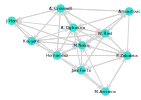

In [12]:
g_a = gplot(aggregateA, nodelabel=playernamesA)

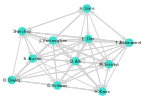

In [13]:
g_b = gplot(aggregateB, nodelabel=playernamesB)

In [21]:

draw(PNG("aggregate_B.png", 16cm, 16cm), g_b)

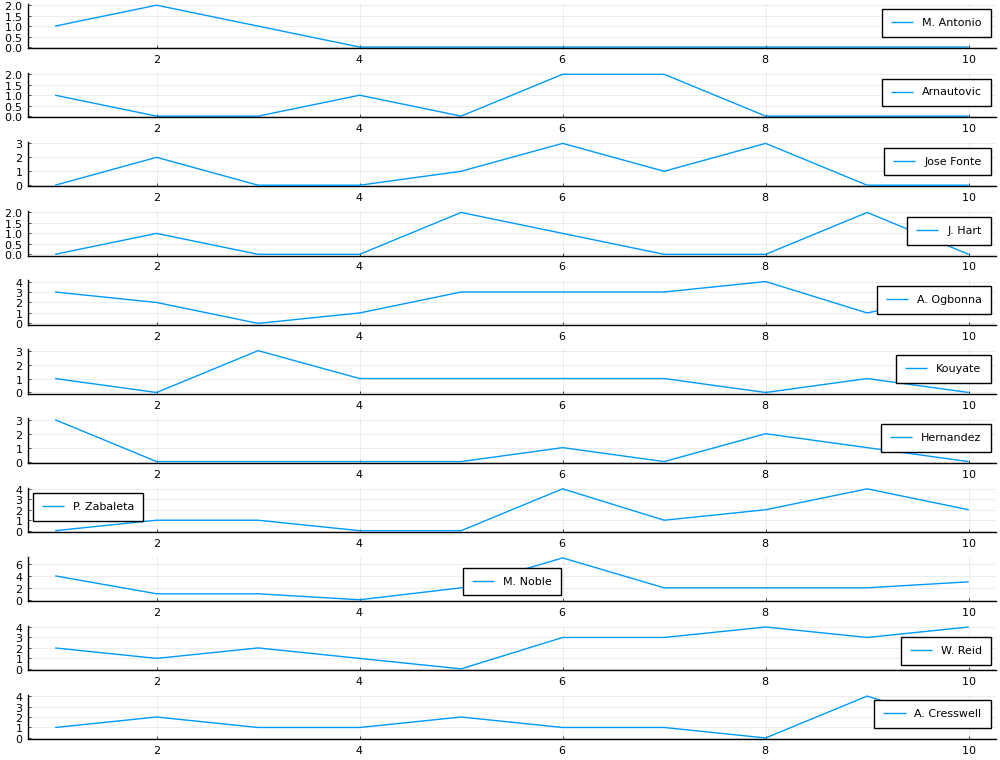

In [282]:
plot(1:num_frames,degree_centA, labels = playernamesA, layout = (11,1))

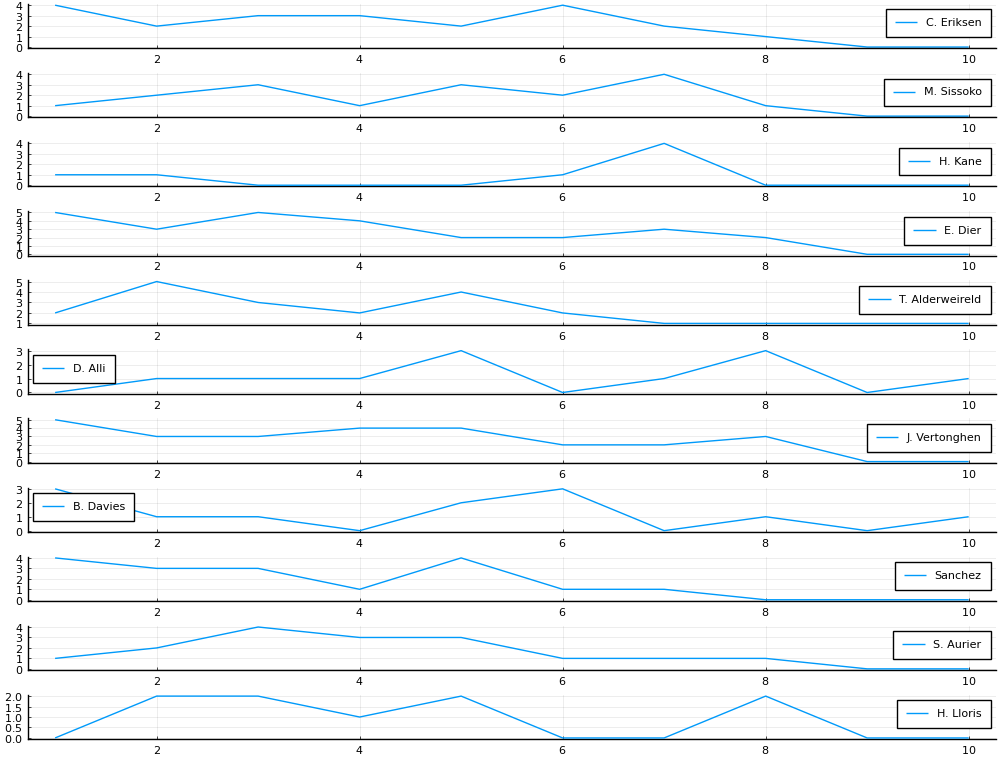

In [28]:
plot(1:num_frames,degree_centB, labels = playernamesB, layout = (11,1))

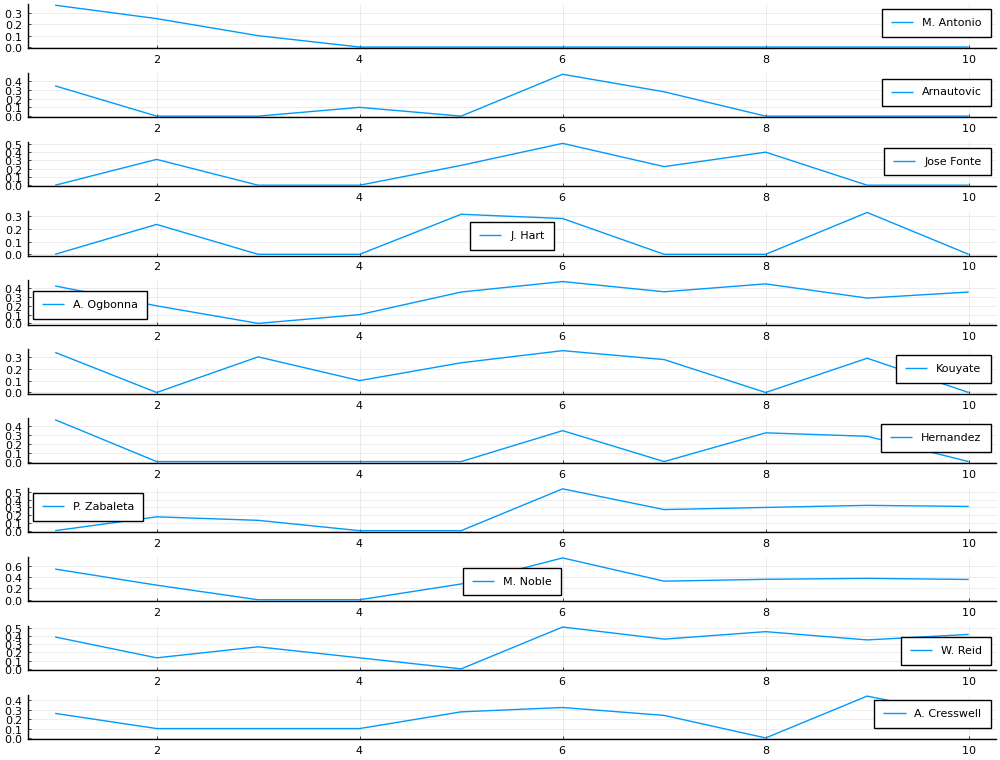

In [29]:
y_A = zeros(num_frames,11)
y_B = zeros(num_frames,11)
x = 1:num_frames
for j = 1:10
    y_A[j, :] = closeness[j,1]
    y_B[j, :] = closeness[j,2]
end

plot(x,y_A, labels = playernamesA, layout = (11,1))

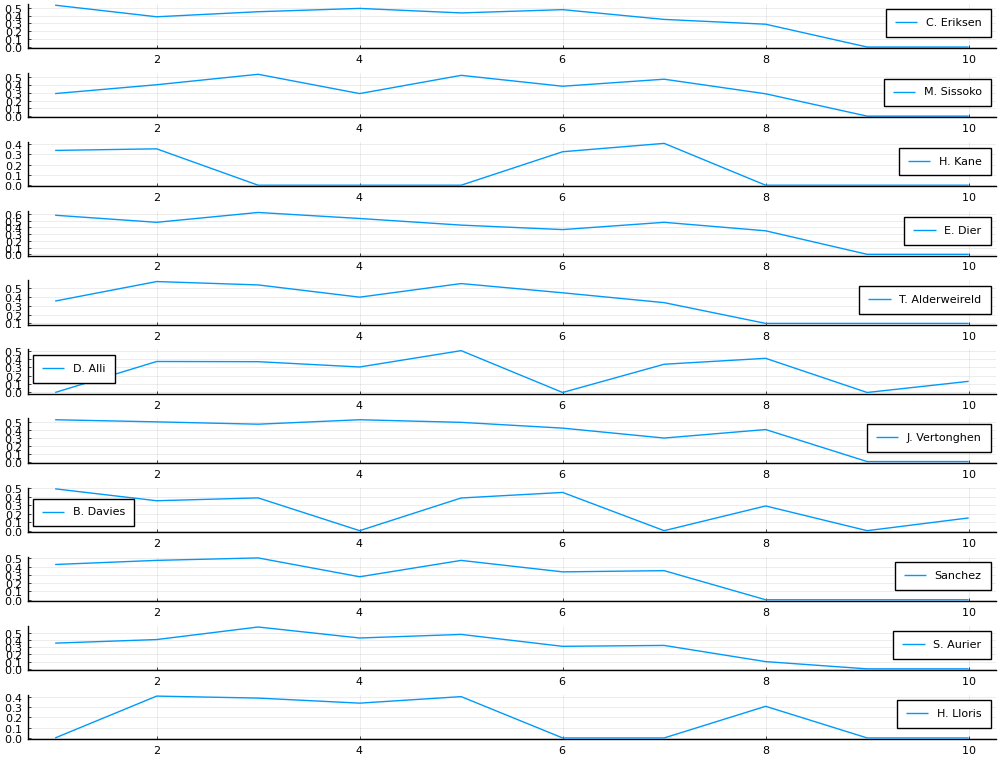

In [30]:
plot(x,y_B, labels = playernamesB, layout = (11,1))

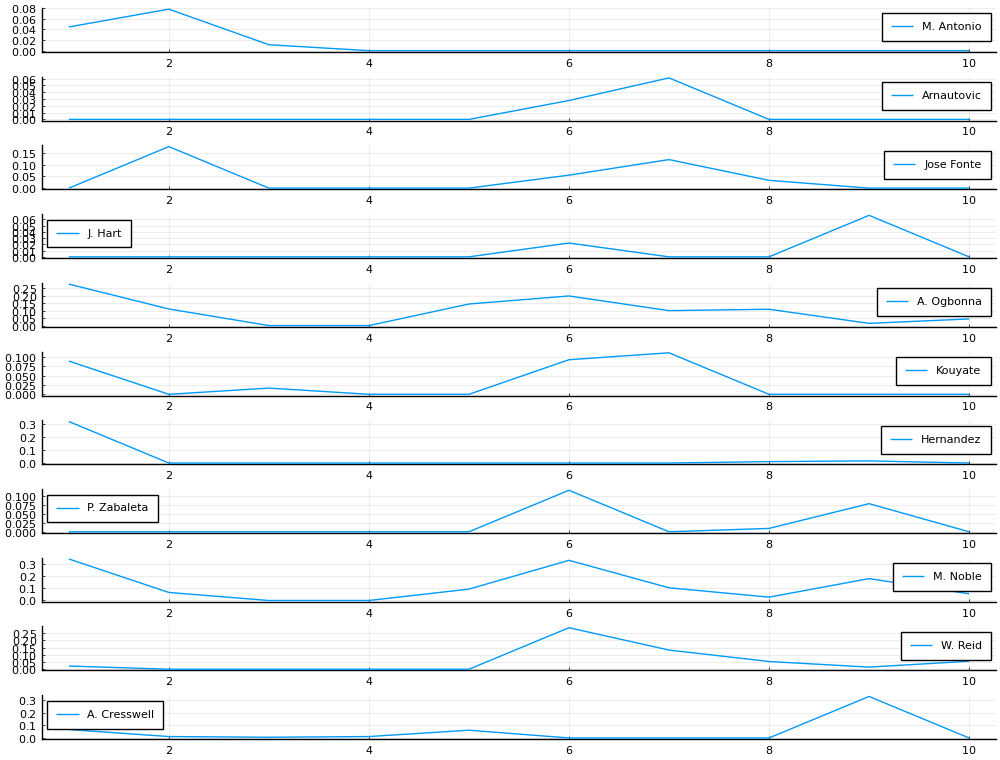

In [31]:
y_A = zeros(num_frames,11)
y_B = zeros(num_frames,11)
x = 1:num_frames
for j = 1:10
    y_A[j, :] = betweenness[j,1]
    y_B[j, :] = betweenness[j,2]
end

plot(x,y_A, labels = playernamesA, layout = (11,1))

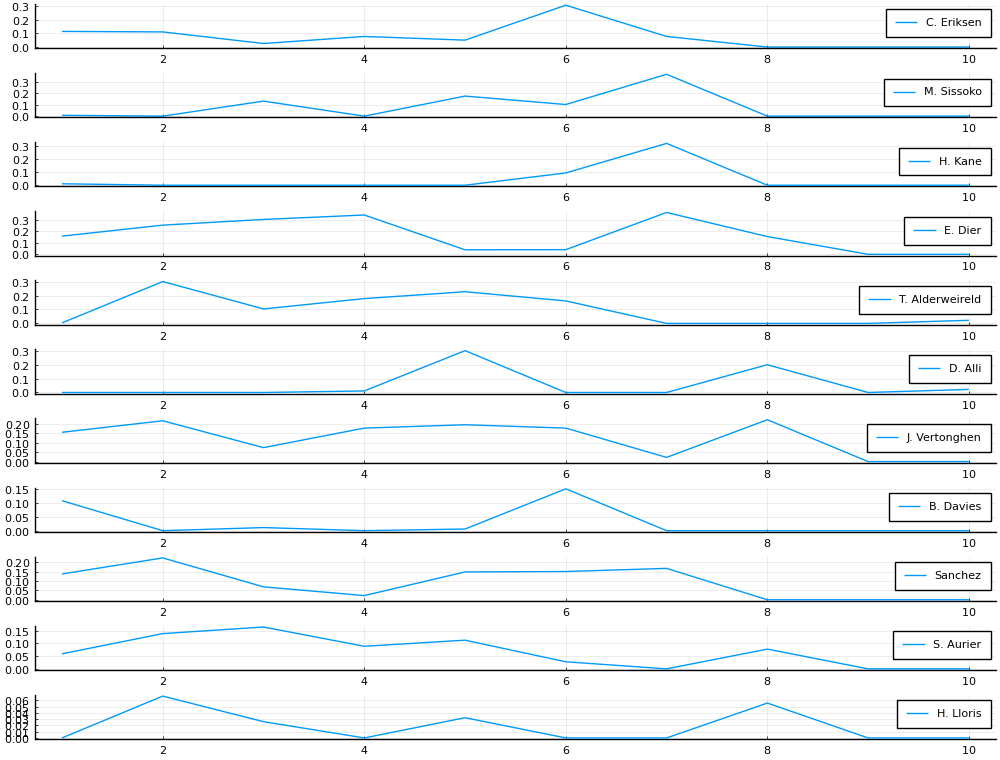

In [33]:
plot(x,y_B, labels = playernamesB, layout = (11,1))

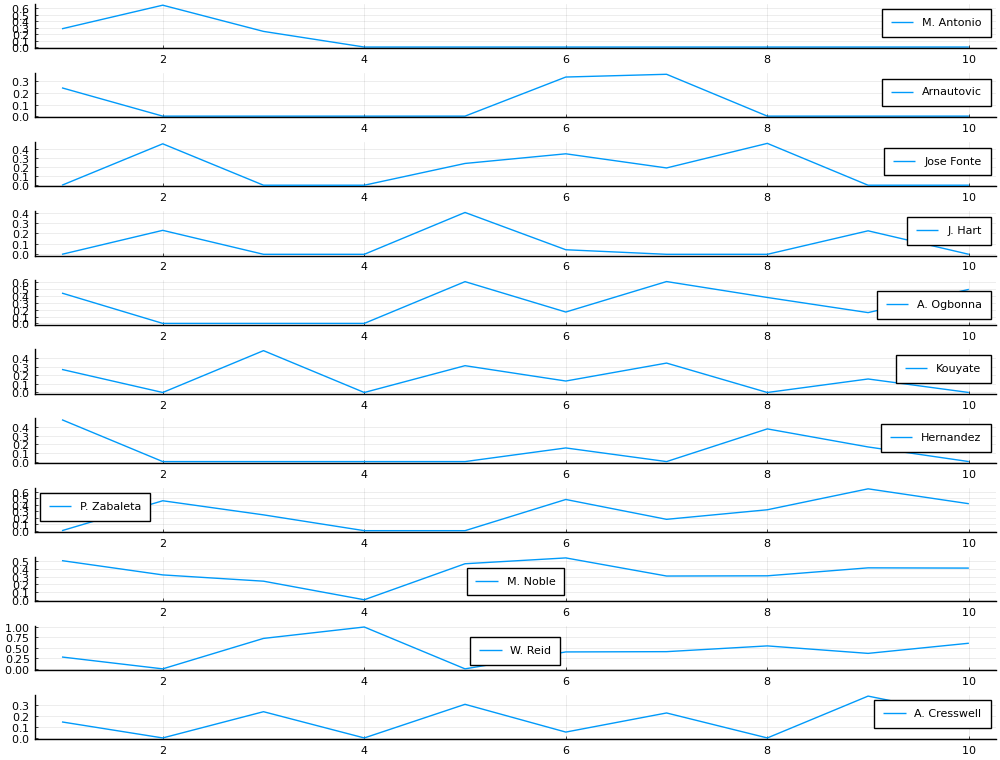

In [263]:
y_A = zeros(num_frames,11)
y_B = zeros(num_frames,11)
x = 1:num_frames
for j = 1:10
    y_A[j, :] = eigens[j,1]
    y_B[j, :] = eigens[j,2]
end

plot(x,y_A, labels = playernamesA, layout = (11,1))

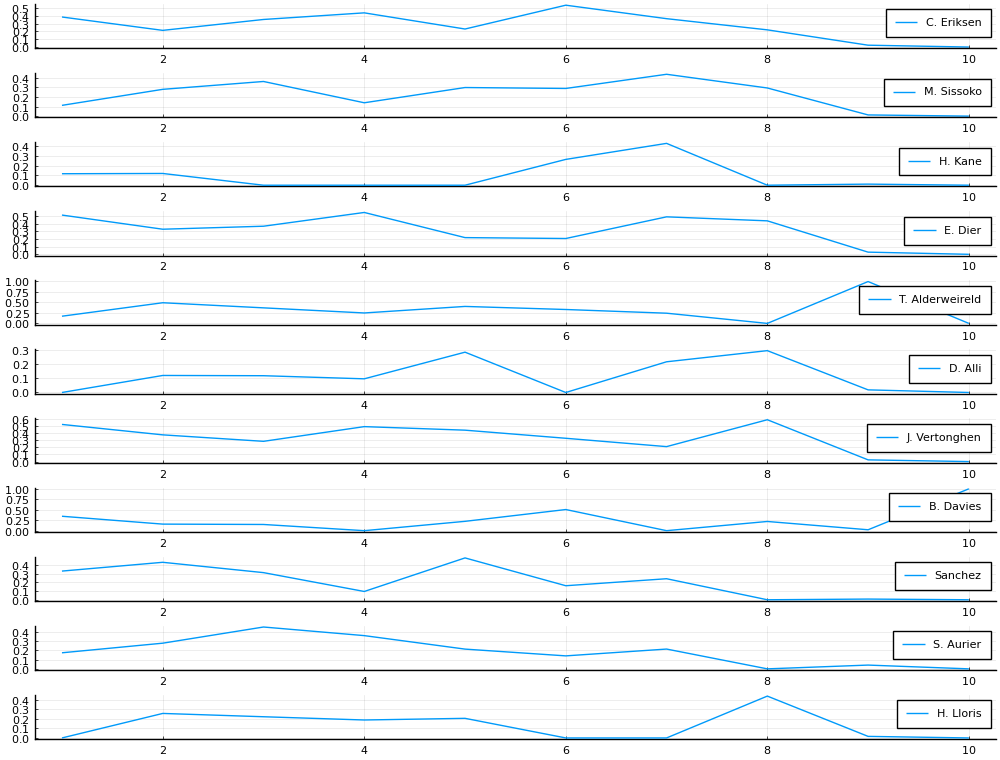

In [264]:
plot(x,y_B, labels = playernamesB, layout = (11,1))

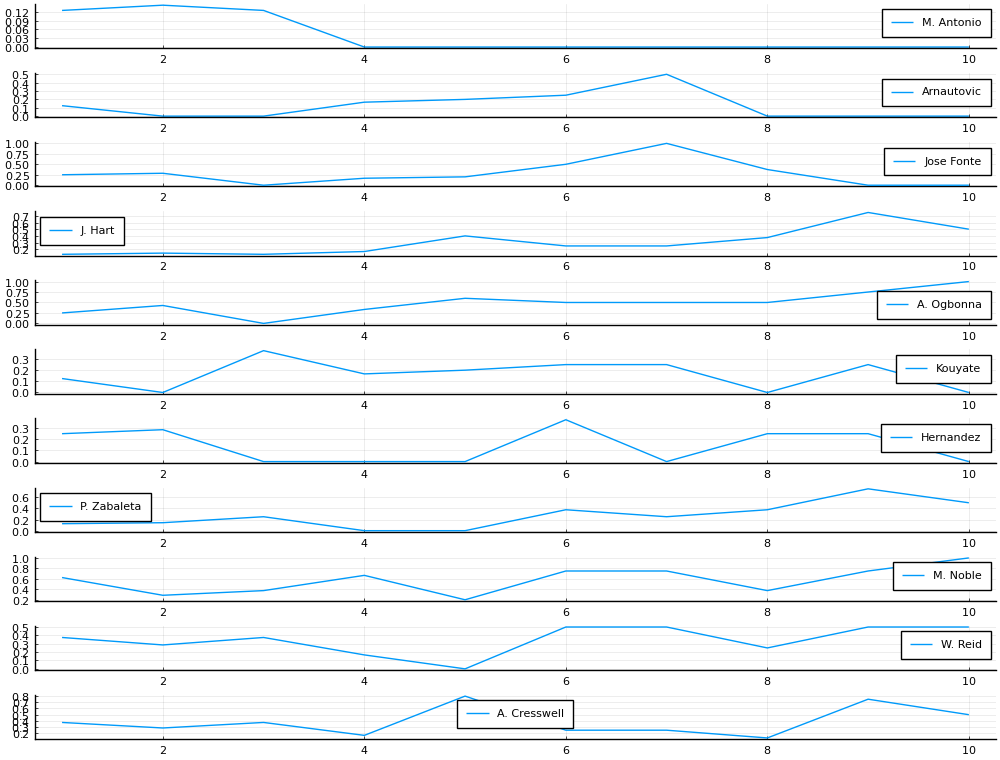

In [34]:
y_A = zeros(num_frames,11)
y_B = zeros(num_frames,11)
x = 1:num_frames
for j = 1:10
    y_A[j, :] = flowBetweenness[j,1]
    y_B[j, :] = flowBetweenness[j,2]
end

plot(x,y_A, labels = playernamesA, layout = (11,1))

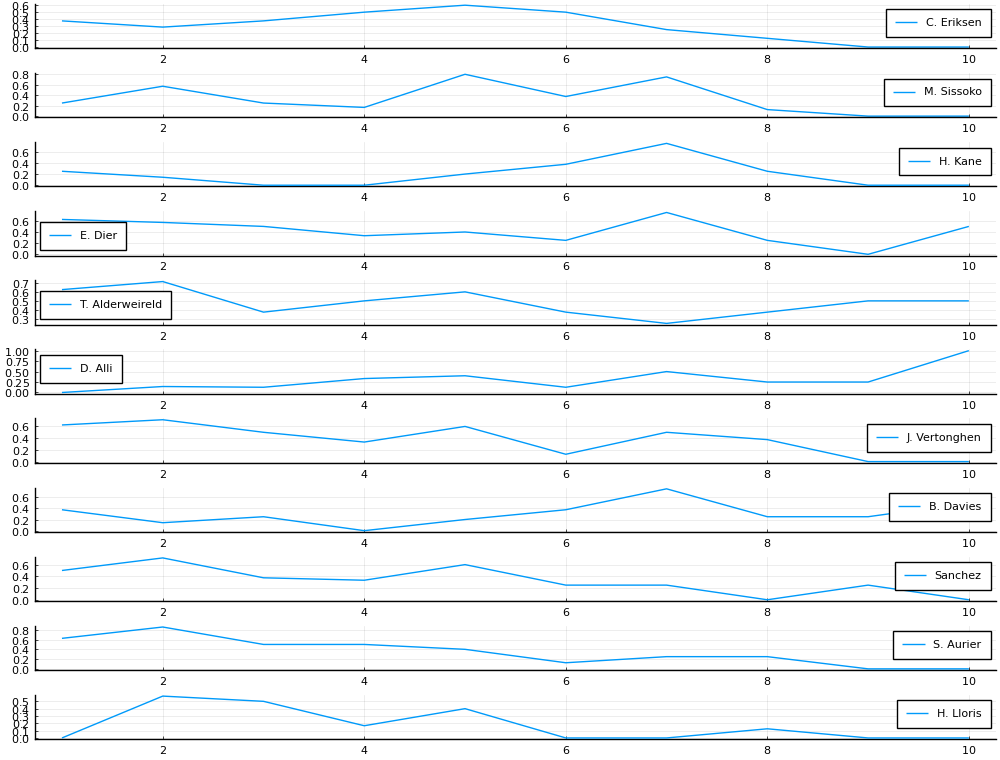

In [35]:
plot(x,y_B, labels = playernamesB, layout = (11,1))

In [23]:
# Calculate aggregate degree centrality for all players in both teams
edge_weightsA = adjacency_matrix(aggregateA)
edge_weightsB = adjacency_matrix(aggregateB)

agg_degree_centA = zeros(1,11)
agg_degree_centB = zeros(1,11)
for i = 1:11
    agg_degree_centA[i] = sum(edge_weightsA[i,:])
    agg_degree_centB[i] = sum(edge_weightsB[i,:])
end
#degree_centA[1] = 30


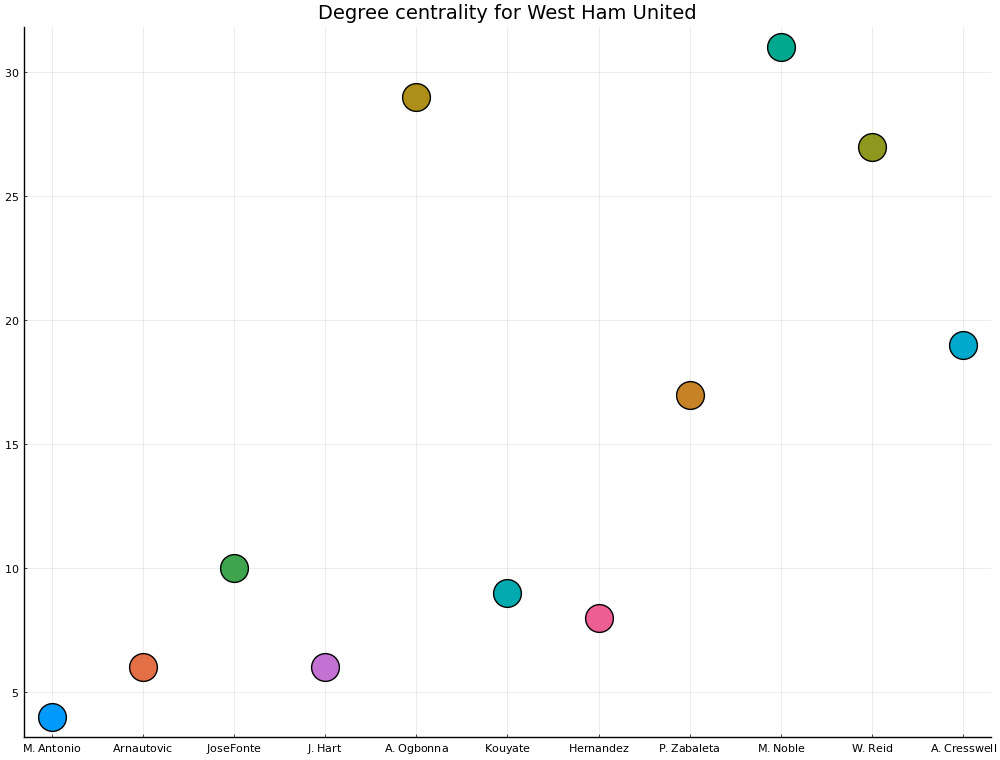

In [24]:
scatter(playernamesA, agg_degree_centA, labels = nothing, markersize = 20, title = "Degree centrality for $teamAname")

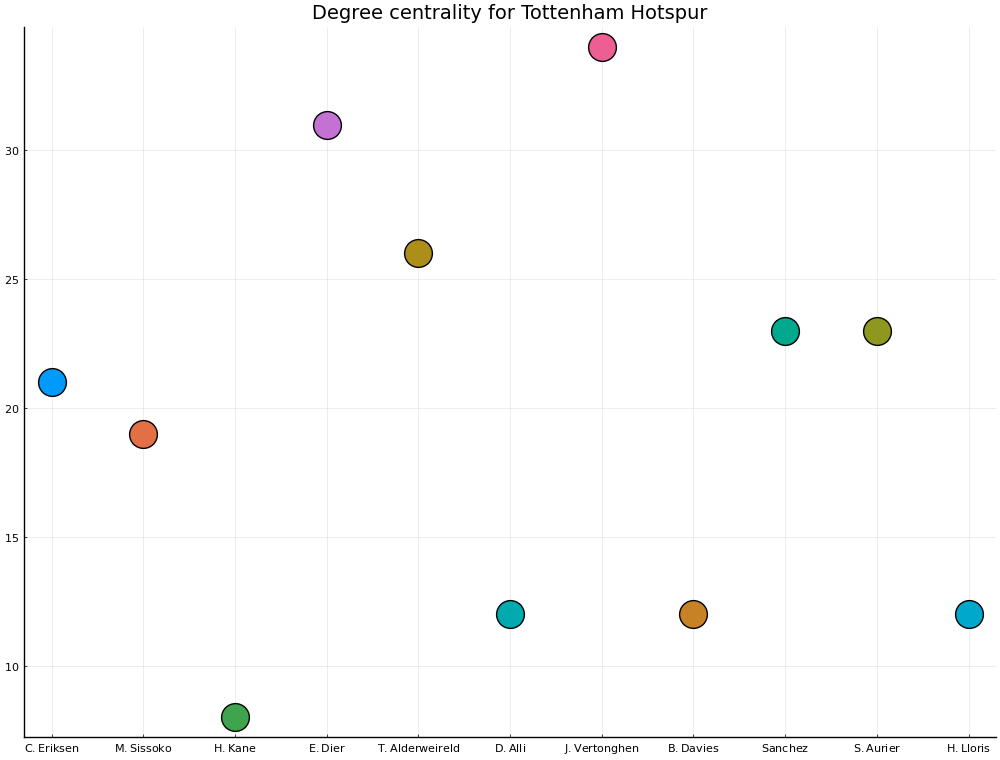

In [25]:
scatter(playernamesB, agg_degree_centB, labels = nothing, markersize = 20, title = "Degree centrality for $teamBname")

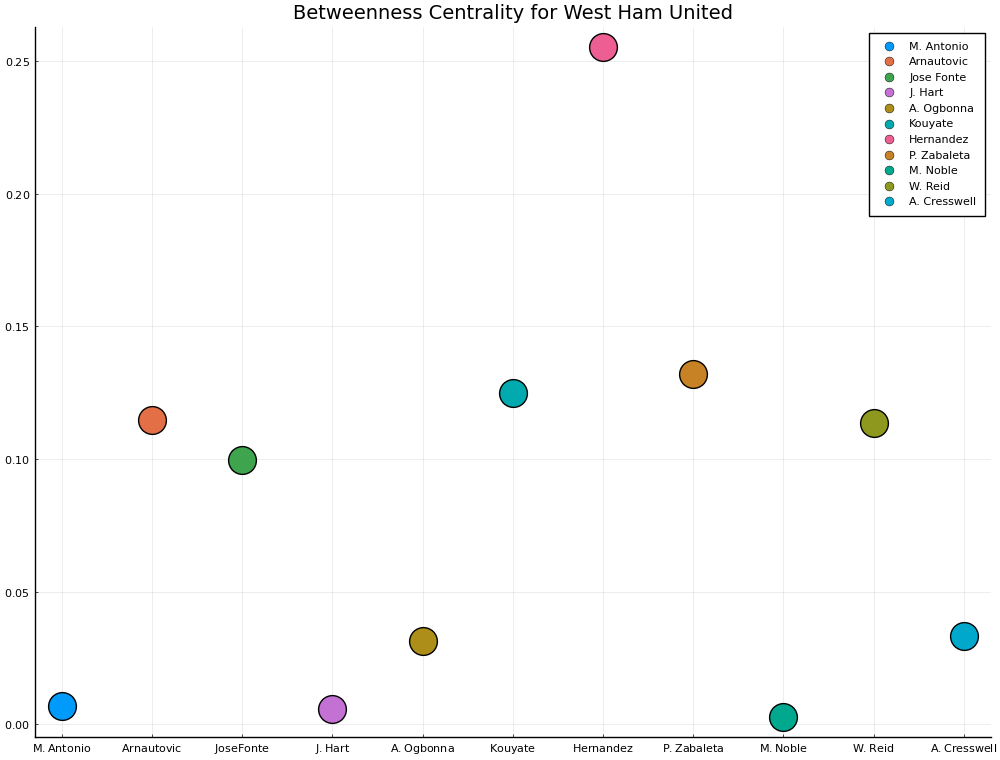

In [26]:
scatter(playernamesA, betweenness_centrality(aggregateA)', labels = playernamesA, markersize = 20, title = "Betweenness Centrality for $teamAname")

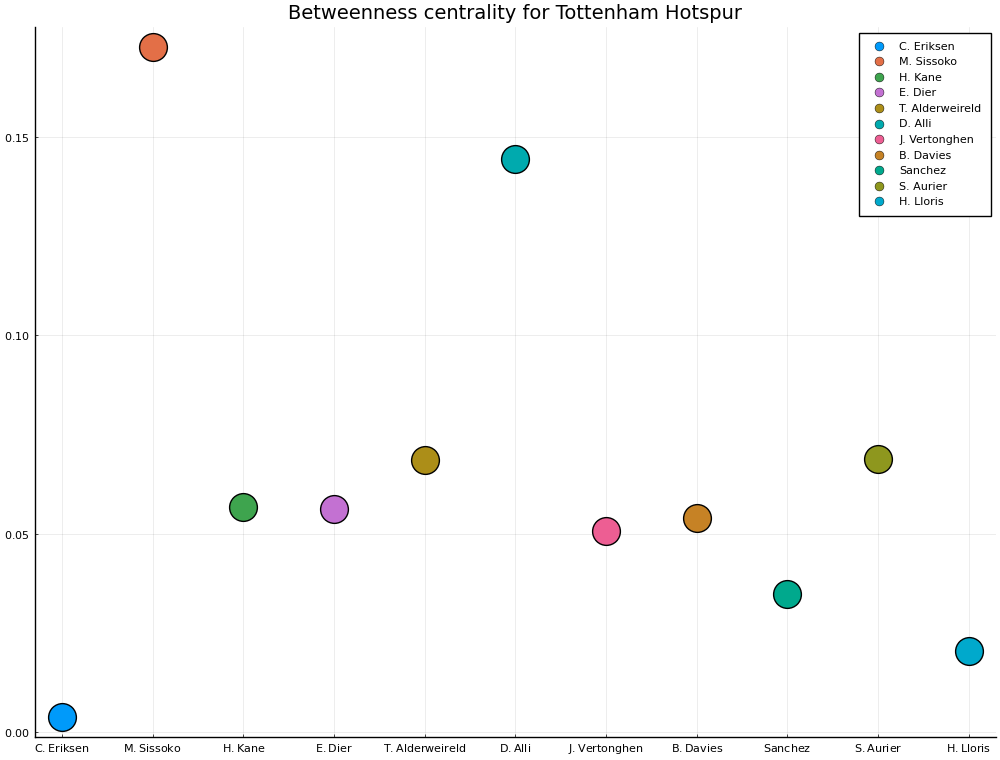

In [27]:
scatter(playernamesB, betweenness_centrality(aggregateB)', labels = playernamesB, markersize = 20, title = "Betweenness centrality for $teamBname")

In [110]:
#scatter(playernamesB, clustering_coefficientsB, label = playernamesB, markersize = 20, title = "Clustering Coefficients for Wales")

for kv in matches
   println(kv["label"], " ", kv["wyId"])
end



Burnley - AFC Bournemouth, 1 - 2 2500089
Crystal Palace - West Bromwich Albion, 2 - 0 2500090
Huddersfield Town - Arsenal, 0 - 1 2500091
Liverpool - Brighton & Hove Albion, 4 - 0 2500092
Manchester United - Watford, 1 - 0 2500093
Newcastle United - Chelsea, 3 - 0 2500094
Southampton - Manchester City, 0 - 1 2500095
Swansea City - Stoke City, 1 - 2 2500096
Tottenham Hotspur - Leicester City, 5 - 4 2500097
West Ham United - Everton, 3 - 1 2500098
West Ham United - Manchester United, 0 - 0 2500028
Manchester City - Brighton & Hove Albion, 3 - 1 2500024
Tottenham Hotspur - Newcastle United, 1 - 0 2500027
Leicester City - Arsenal, 3 - 1 2500022
Chelsea - Huddersfield Town, 1 - 1 2500062
Swansea City - Southampton, 0 - 1 2500026
Arsenal - Burnley, 5 - 0 2500080
Chelsea - Liverpool, 1 - 0 2500082
Manchester City - Huddersfield Town, 0 - 0 2500085
Everton - Southampton, 1 - 1 2500083
AFC Bournemouth - Swansea City, 1 - 0 2500079
Leicester City - West Ham United, 0 - 2 2500084
Watford - Newcast